Please use GPU from Google Collab or Kaggle

refrence:
- https://medium.com/@sauravjoshi23/optimizing-retrieval-augmentation-with-dynamic-top-k-tuning-for-efficient-question-answering-11961503d4ae

In [1]:
!pip install -q pyarrow==14.0.0
!pip install transformers sentence_transformers faiss-gpu -q
!pip install datasets==2.17.0 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset(path="FinGPT/fingpt-fiqa_qa", split="train")
dataset

Generating train split:   0%|          | 0/17110 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 17110
})

In [ ]:
dataset.to_pandas()

,input,output,instruction
0,What is considered a business expense on a bus...,The IRS Guidance pertaining to the subject. I...,"Utilize your financial knowledge, give your an..."
1,Claiming business expenses for a business with...,Yes you can claim your business deductions if ...,Offer your insights or judgment on the input f...
2,Transferring money from One business checking ...,You should have separate files for each of the...,"Based on your financial expertise, provide you..."
3,Having a separate bank account for business/in...,Having a separate checking account for the bus...,Share your insights or perspective on the fina...
4,Having a separate bank account for business/in...,"You don't specify which country you are in, so...",Offer your thoughts or opinion on the input fi...
...,...,...,...
17105,"Pensions, annuities, and “retirement”","An annuity is a product. In simple terms, you ...","Utilize your financial knowledge, give your an..."
17106,What does it mean to a life insurance policy h...,A stock insurance company is structured like a...,Offer your insights or judgment on the input f...
17107,Can capital loss in traditional IRA and Roth I...,Edited in response to JoeTaxpayer's comment an...,"Based on your financial expertise, provide you..."
17108,Can capital loss in traditional IRA and Roth I...,"No, you cannot. If you withdraw everything fro...",Share your insights or perspective on the fina...


In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import numpy as np

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
question_token_counts = [len(tokenizer.tokenize(example["input"])) for example in dataset]
answer_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset]
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset]
combined_token_counts = [q + a + inst for q, a, inst in zip(question_token_counts, answer_token_counts, instruction_token_counts)]

In [ ]:
def plot_distribution(token_counts: List[int], title: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n")
    average_tokens = np.mean(token_counts)
    print(f"Average distribution tokens {np.round(average_tokens, 0)}")


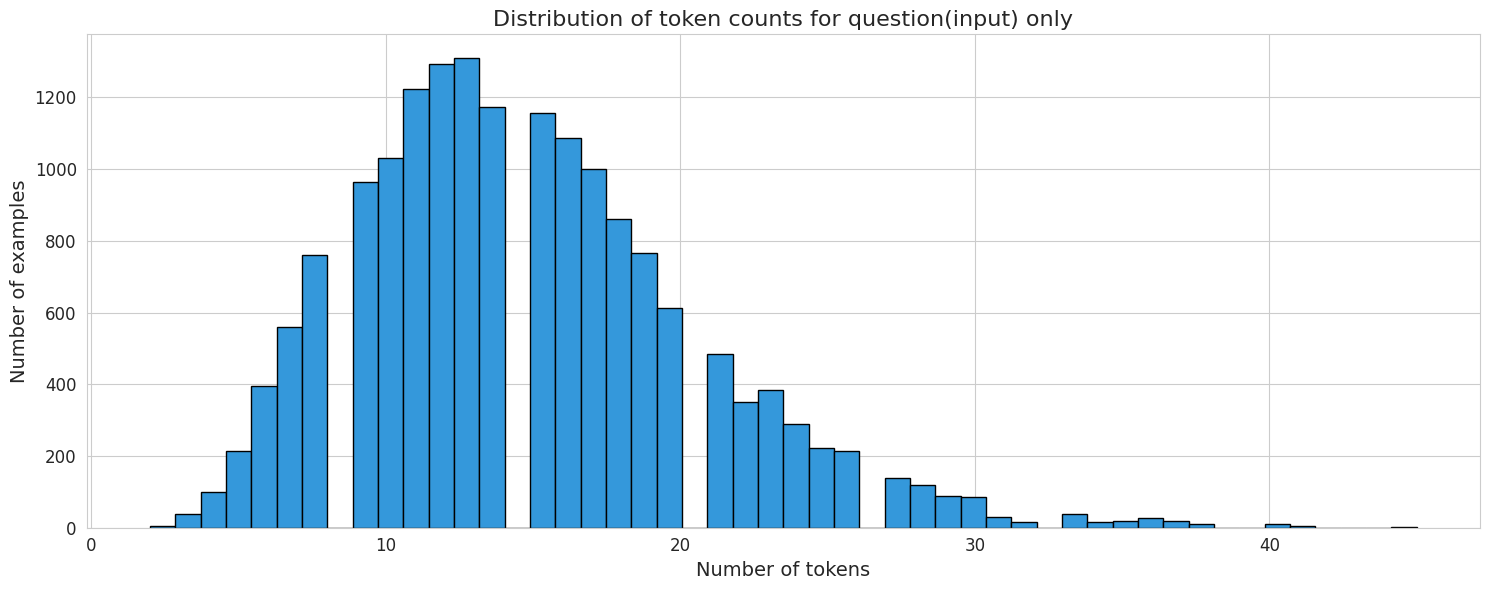



Average distribution tokens 15.0


In [ ]:
# Plot the distribution of token counts
plot_distribution(question_token_counts, "Distribution of token counts for question(input) only")

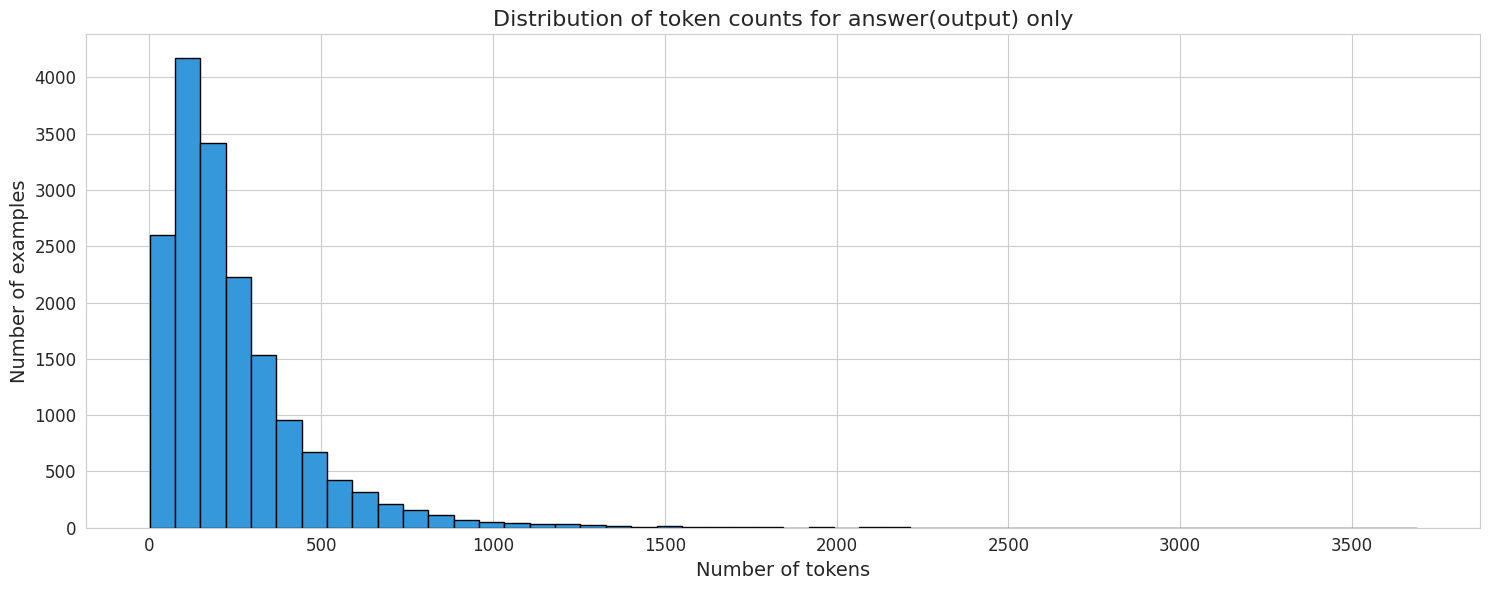



Average distribution tokens 243.0


In [ ]:
plot_distribution(answer_token_counts, "Distribution of token counts for answer(output) only")

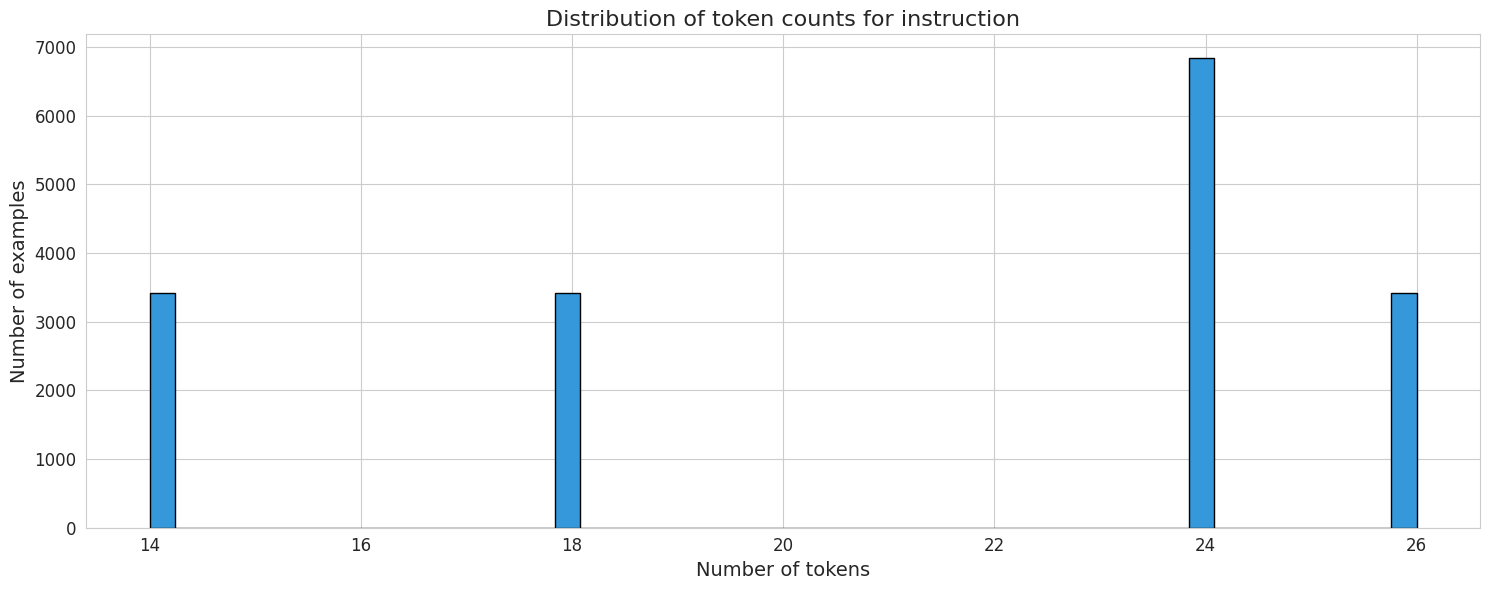



Average distribution tokens 21.0


In [ ]:
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction")

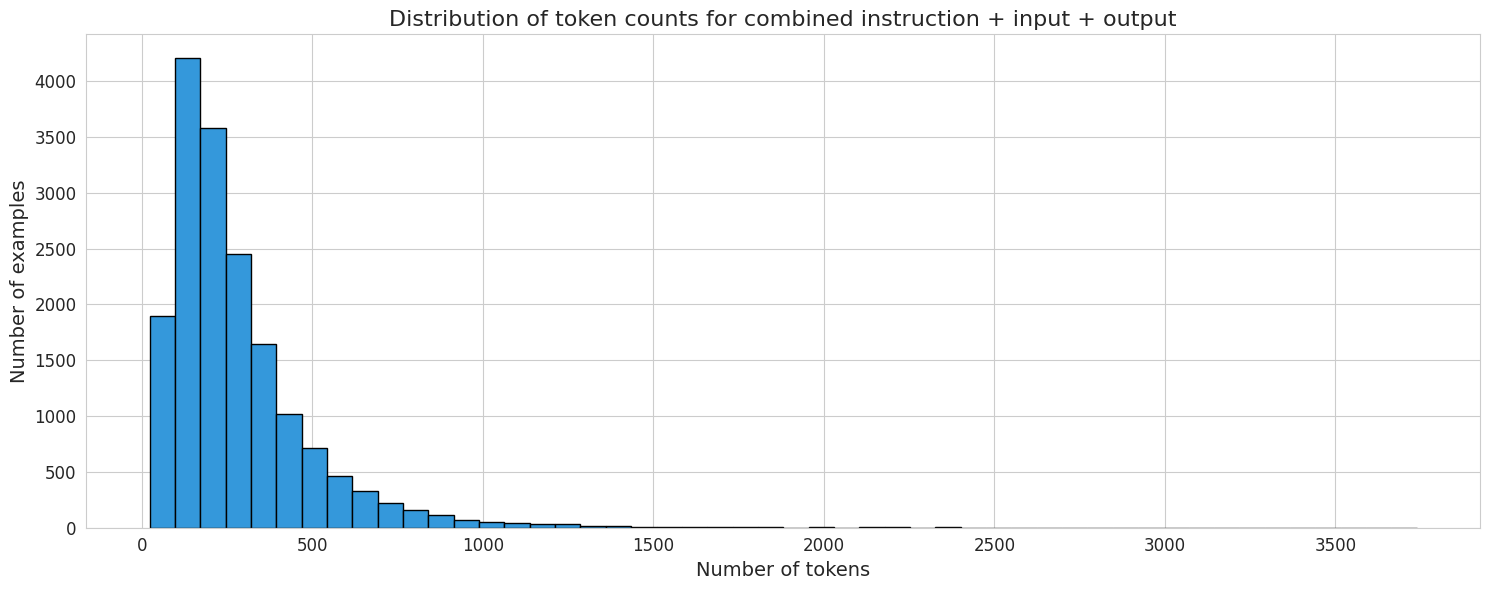



Average distribution tokens 279.0


In [ ]:
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + input + output")

## Filter out rows with more than 512 tokens
because the average token dataset is 280, then I will delete token lengths more than 512 (outliers)

Number of valid rows: 15253
Removing 1857 rows...


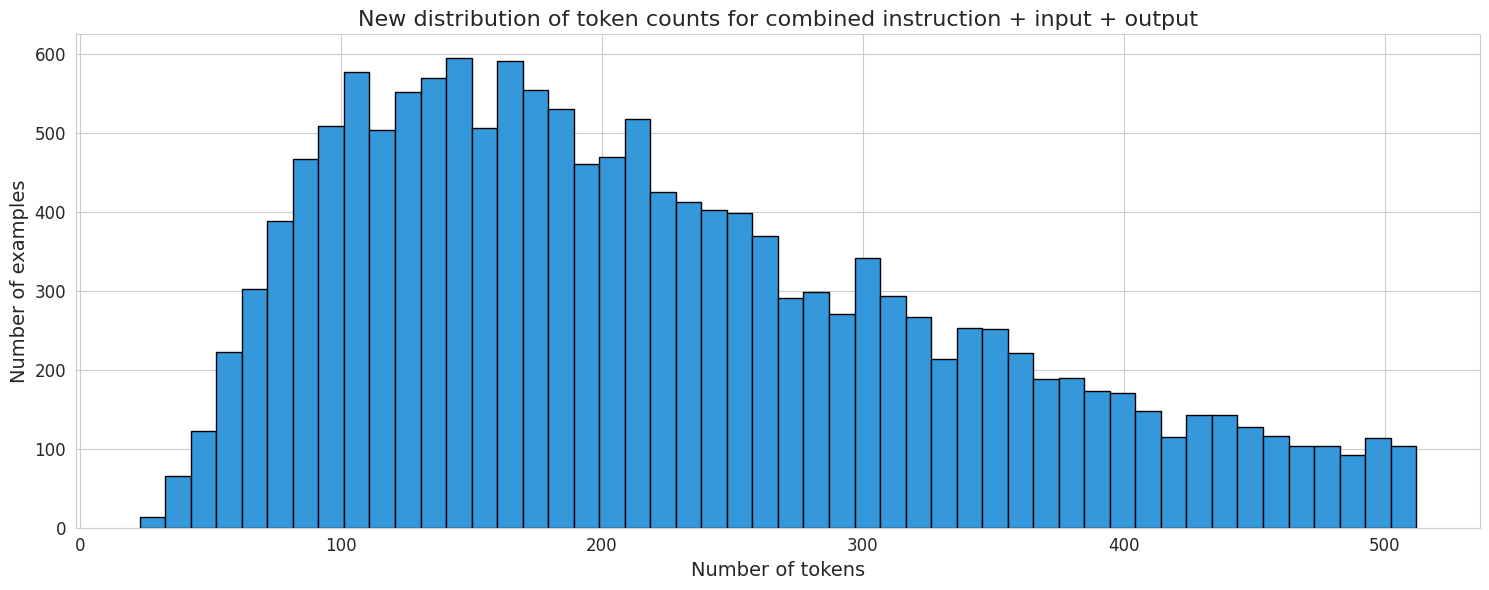



Average distribution tokens 222.0


In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 512]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset) - len(valid_indices)} rows...")

# Extract valid rows based on indices
new_dataset = dataset.select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + input + output")

You can see, we still have a lot of datasets...

## Near-deduplication using embeddings
The "Near-deduplication using embeddings" technique in data processing refers to an approach to identifying and removing near-duplicates data using an embedding representation of that data.

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

In [ ]:
def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset.select(to_keep)
    return DatasetDict({"train": dataset})


In [ ]:
deduped_dataset = deduplicate_dataset(new_dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/477 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/15253 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(new_dataset)}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(new_dataset) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 15253
Number of samples in the deduped dataset: 15164
Number of samples that were removed: 89


In [ ]:
deduped_dataset["train"]

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 15164
})

## Top-K Sampling

In [ ]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "input": [dataset['train'][i]["input"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data), top_k_data

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
input_token_counts = [len(tokenizer.tokenize(example["input"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + input_ + output for instruction, input_, output in zip(instruction_token_counts, input_token_counts, output_token_counts)]

k = 2000  # You can adjust this value as needed
top_k_dataset, data = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

In [ ]:
dataset["train"][1001]

{'instruction': 'Share your insights or perspective on the financial matter presented in the input.',
 'input': 'How and why does the exchange rate of a currency change almost everyday?',
 'output': 'Money is money because people believe it is money. By "believe it is money", I mean that they expect they will be able to turn it into useful goods or services (food, rent, houses, truckloads full of iron ore, mining equipment, massages at the spa, helicopter rides, iPads, greenhouses, income streams to support your future retirement, etc). Foreign exchange rates change because people\'s ideas about how much useful goods or services they can get with various currencies change. For example: if the Zimbabwe government suddenly printed 10 times as much money as used to exist, you probably couldn\'t use that money to buy as much food at the Zimbabwe-Mart, so you wouldn\'t be willing to give people as many US-dollars (which can buy food at the US-Mart) for a Zimbabwe-dollar as you used to be ab

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
input_token_counts = [len(tokenizer.tokenize(example["input"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + input_ + output for instruction, input_, output in zip(instruction_token_counts, input_token_counts, output_token_counts)]

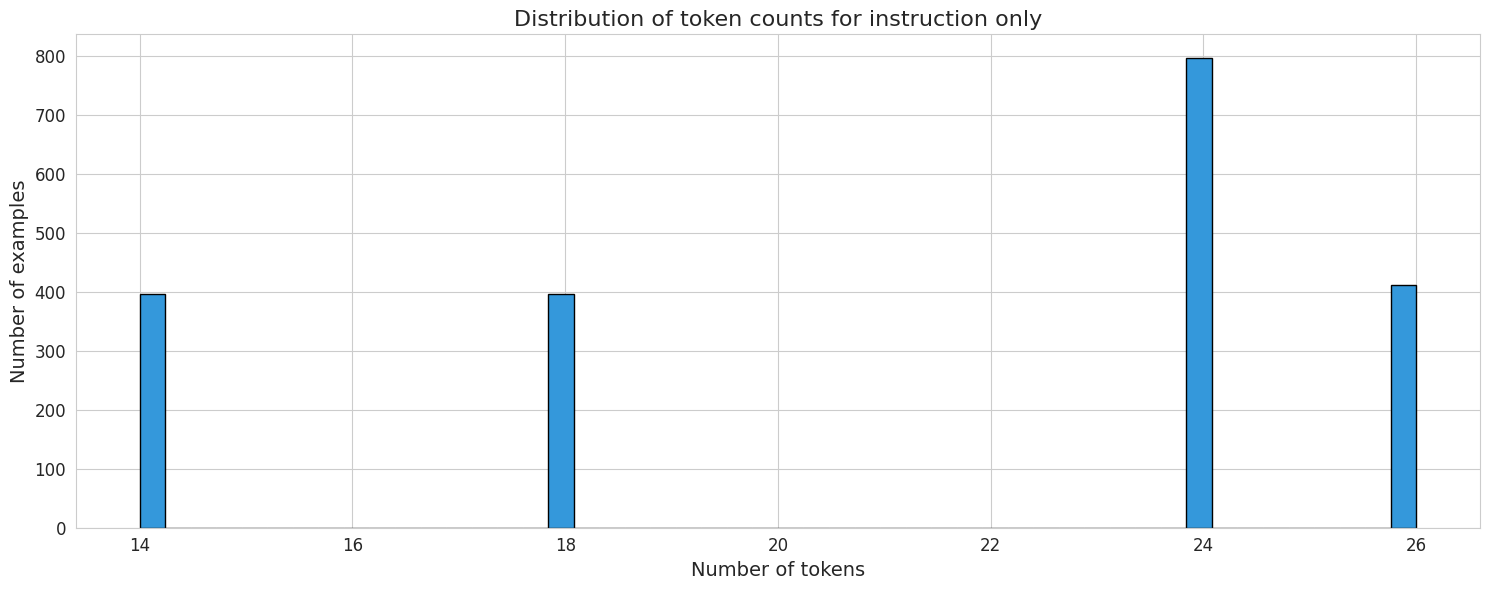



Average distribution tokens 21.0


In [ ]:
# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")

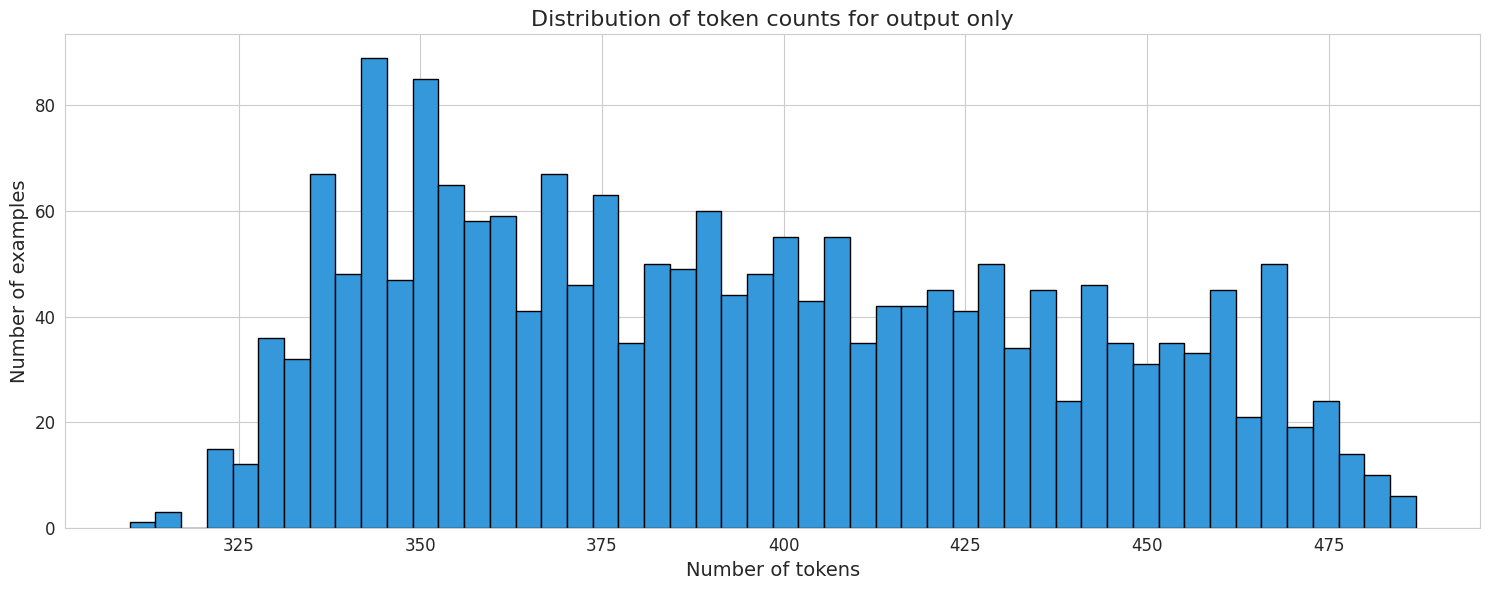



Average distribution tokens 394.0


In [ ]:
plot_distribution(output_token_counts, "Distribution of token counts for output only")

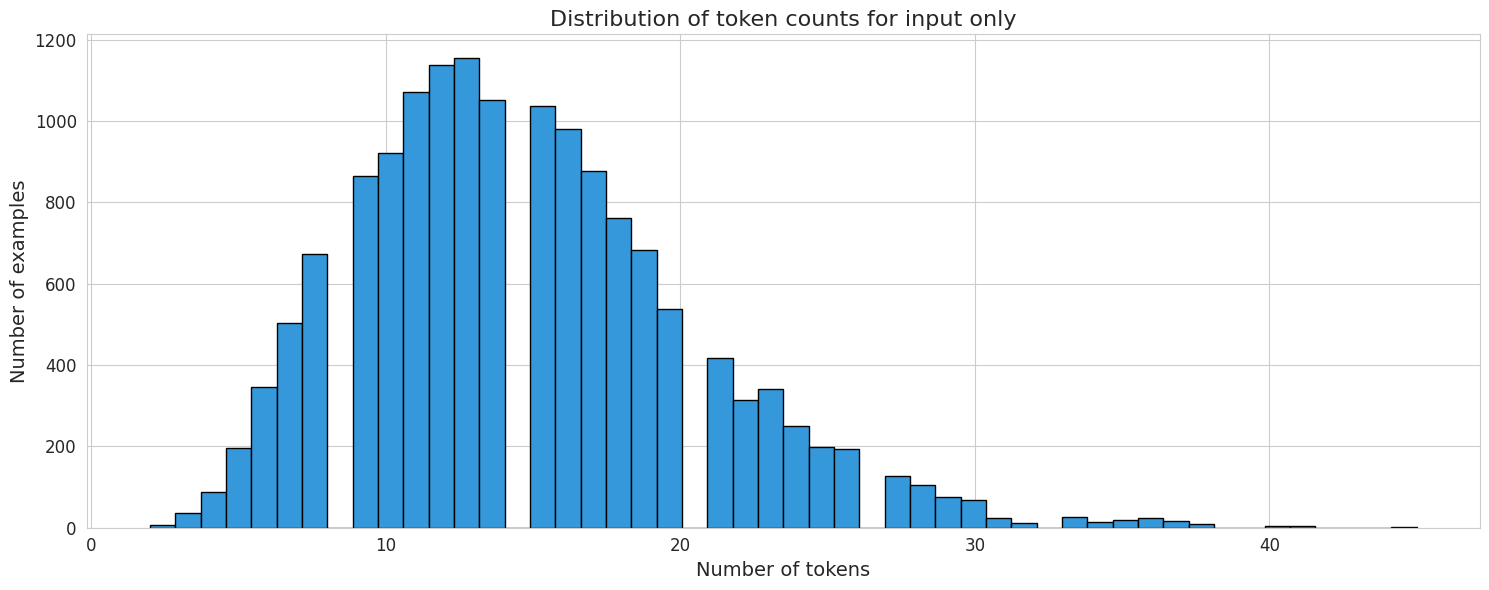



Average distribution tokens 15.0


In [ ]:
plot_distribution(input_token_counts, "Distribution of token counts for input only")

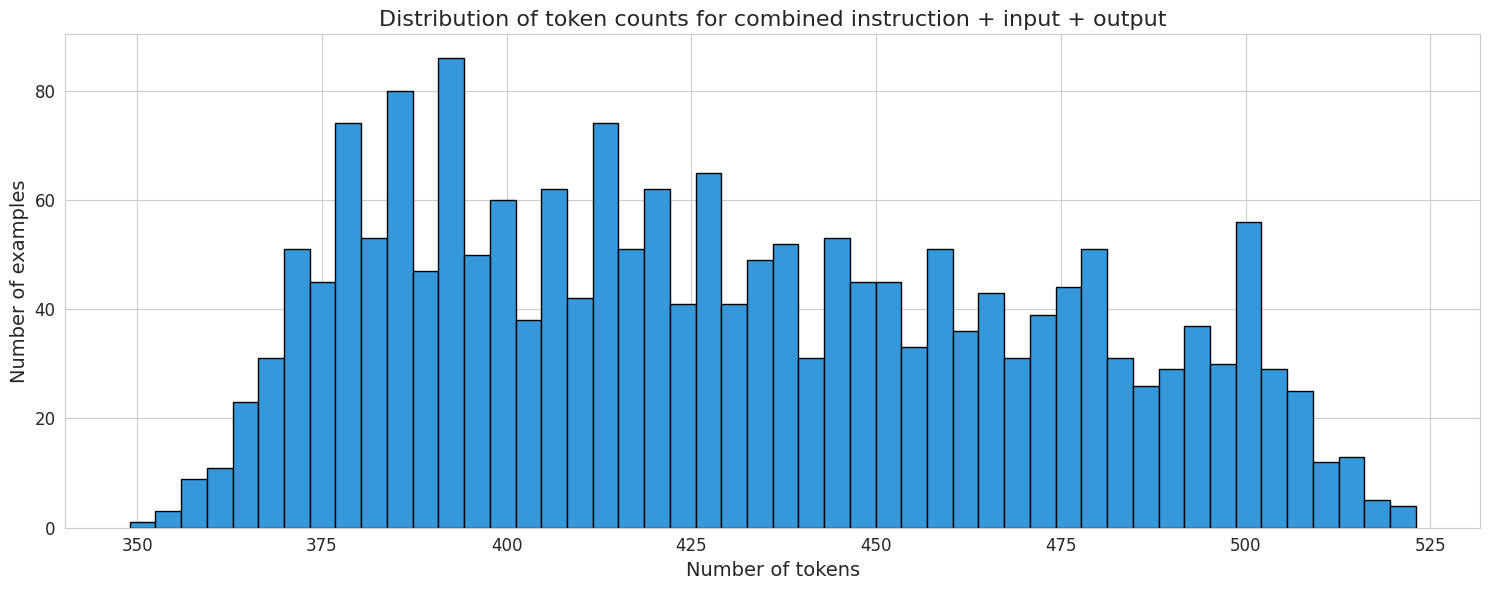



Average distribution tokens 430.0


In [ ]:
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + input + output")

In [35]:
# Save to json format
import json
new_data = dataset.train_test_split(test_size=0.2)
train = new_data["train"]
test = new_data["test"]

In [37]:
train_data = []

for i, inst in enumerate(train["instruction"]):
    x = {
        "instruction": inst,
        "input": train["input"][i],
        "output": train["output"][i]
    }
    train_data.append(x)

with open("data/training_dataset.json", "w") as json_file:
    json.dump(train_data, json_file, indent=4)


In [38]:
test_data = []

for i, inst in enumerate(test["instruction"]):
    x = {
        "instruction": inst,
        "input": test["input"][i],
        "output": test["output"][i]
    }
    test_data.append(x)

with open("data/testing_dataset.json", "w") as json_file:
    json.dump(test_data, json_file, indent=4)
